In [39]:
import io
import re
import os
import tqdm
import shutil
import string

import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px 

from sklearn.cluster import KMeans
from tensorflow.keras import Model
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import Dot, Embedding, Flatten

In [40]:
SEED=123

In [41]:
df = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/NLP/french_reviews.csv")

In [42]:
df = df[df["review_format_clean"].apply(lambda x: isinstance(x, str))]

In [43]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)

In [44]:
tokenizer.fit_on_texts(df["review_format_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_format_clean"])

In [45]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  
  targets, contexts, labels = [], [], []

  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  for sequence in tqdm.tqdm(sequences):

    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table, 
          window_size=window_size,
          negative_samples=0)

    for target_word, context_word in positive_skip_grams:
      
      target_word = tf.expand_dims(tf.constant([target_word], dtype="int64"),1)
     
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")

      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1) 

      
      context = tf.concat([context_class, negative_sampling_candidates], 0)
     
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [46]:
vocab_size = tokenizer.num_words

In [47]:
targets, contexts, labels = generate_training_data(
    sequences=df["review_encoded"],
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 8470/8470 [00:09<00:00, 927.21it/s] 


40501 40501 40501


In [48]:
BATCH_SIZE = 1024
BUFFER_SIZE = len(targets)
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024, 1, 1), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024, 1, 1), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [50]:
embedding_dim = 128

target_embedding = Embedding(vocab_size,
                            embedding_dim,
                            input_length=1,
                            name="w2v_embedding",
                             mask_zero=True)
context_embedding = Embedding(vocab_size,
                              embedding_dim,
                              input_length=4+1,
                              name="context_embedding")
dots = Dot(axes=3,name="dot_product")
flatten = Flatten()

In [51]:
target = tf.keras.Input(shape=[1,1], name="target")

context = tf.keras.Input(shape=[5,1], name="context")

word_emb = target_embedding(target)

context_emb = context_embedding(context)

dots_result = dots([context_emb, word_emb])

flat = flatten(dots_result)

output = tf.keras.activations.sigmoid(flat)

word2vec = tf.keras.Model(inputs=[target,context], outputs=output)

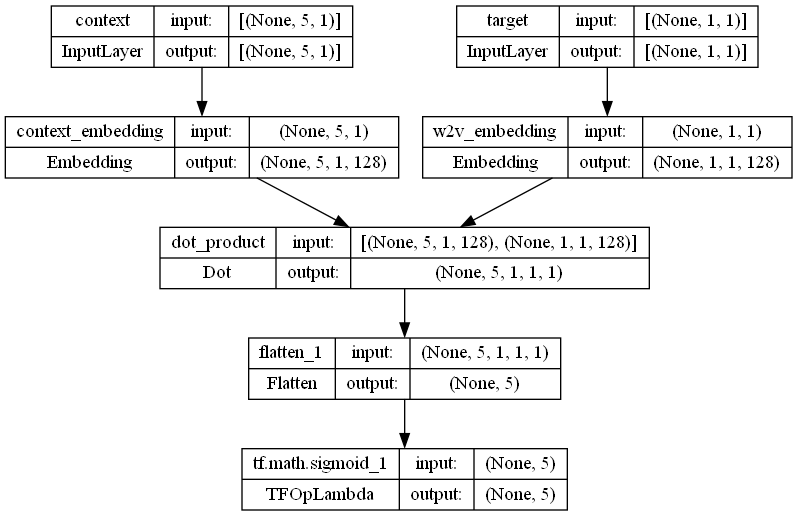

In [52]:
tf.keras.utils.plot_model(word2vec, show_shapes=True)

In [53]:
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [55]:
word2vec.fit(dataset, epochs=40, callbacks=[tensorboard_callback])

Epoch 1/40
39/39 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.2336
Epoch 2/40
39/39 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.3289
Epoch 3/40
39/39 [==============================] - 0s 3ms/step - loss: 0.5758 - accuracy: 0.2705
Epoch 4/40
39/39 [==============================] - 0s 3ms/step - loss: 0.5067 - accuracy: 0.2640
Epoch 5/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4866 - accuracy: 0.2786
Epoch 6/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4790 - accuracy: 0.3040
Epoch 7/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4744 - accuracy: 0.3270
Epoch 8/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4703 - accuracy: 0.3475
Epoch 9/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.3724
Epoch 10/40
39/39 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.4024
Epoch 11/40
39/39 [

In [56]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [57]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3680), started 0:08:29 ago. (Use '!kill 3680' to kill it.)

In [58]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = [value for value in tokenizer.index_word.values()][:1000]

In [59]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [60]:
text_encoded = tokenizer.texts_to_sequences(df["review_format_clean"])
text_encoded_padded = tf.keras.preprocessing.sequence.pad_sequences(text_encoded,
                                                                    padding="post")
text_encoded_padded

array([[ 88, 576,   7, ...,   0,   0,   0],
       [290,  60,   0, ...,   0,   0,   0],
       [366, 766, 442, ...,   0,   0,   0],
       ...,
       [ 23,  27, 106, ...,   0,   0,   0],
       [169,   7, 211, ...,   0,   0,   0],
       [ 17,   9, 371, ...,   0,   0,   0]])

In [61]:
avg_pooling = tf.keras.layers.GlobalAveragePooling1D()

In [62]:
emebedded_text = target_embedding(text_encoded_padded)

In [63]:
emebedded_text.shape

TensorShape([8470, 184, 128])

In [64]:
avg_embedded_text = avg_pooling(emebedded_text).numpy()

In [65]:
avg_embedded_text.shape

(8470, 128)

In [66]:
df_2 = pd.DataFrame(avg_embedded_text)

In [67]:
df_2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.047362,0.172673,-0.251220,-0.089311,0.185636,0.304802,-0.213604,0.294700,0.117808,-0.078289,...,-0.030487,-0.209982,-0.165043,0.050183,0.092619,-0.169062,0.200593,0.176453,-0.079356,0.181816
1,0.072176,0.003730,-0.531338,-0.223512,0.247347,0.022386,-0.325882,0.525758,0.390217,-0.257879,...,-0.018162,-0.349789,-0.073707,0.323848,0.085816,-0.194660,0.208699,0.182881,0.136772,-0.187218
2,-0.060388,-0.000909,-0.097825,-0.065073,0.160150,-0.116102,-0.100132,0.171963,0.051432,-0.224590,...,-0.172677,-0.033715,-0.195991,0.106959,0.057316,-0.182149,0.058005,-0.023132,-0.057878,0.203224
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.203049,0.308810,-0.113922,-0.181603,0.186178,0.021105,-0.185240,0.175915,-0.074270,-0.110936,...,0.003998,-0.114276,-0.111073,0.026018,0.069025,-0.159553,0.166374,-0.057989,-0.169156,0.106151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,-0.108690,0.050859,-0.128237,-0.293710,0.471521,-0.137139,-0.094306,0.083680,0.077367,-0.376763,...,-0.279994,-0.205894,0.049901,0.096510,-0.180678,-0.054109,0.221760,-0.117174,-0.056095,0.164405
8466,-0.148048,0.193489,-0.121438,-0.189367,0.301924,0.020144,-0.094362,0.154642,0.192512,-0.147910,...,-0.056954,-0.040311,0.002549,0.019337,-0.089216,-0.079541,0.120427,0.043698,-0.041552,0.247829
8467,-0.349821,0.086411,-0.071996,-0.387738,0.101243,-0.108135,-0.171771,0.351720,0.288285,-0.556169,...,-0.164883,-0.082872,-0.138023,0.281192,0.259593,-0.043478,0.319581,0.260790,-0.137262,-0.127834
8468,-0.009957,0.110252,-0.147765,-0.144747,0.123570,0.049785,-0.273746,0.264420,0.163572,-0.187109,...,-0.070648,-0.037367,-0.036383,0.047479,0.074216,-0.171334,0.152618,0.055432,-0.200306,0.159582


In [68]:
df_2.isnull().sum()

0      38
1      38
2      38
3      38
4      38
       ..
123    38
124    38
125    38
126    38
127    38
Length: 128, dtype: int64

In [69]:
df_2 = df_2.dropna()

In [70]:
wcss =  []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(df_2)
    wcss.append(kmeans.inertia_)

In [71]:
wcss_frame = pd.DataFrame(wcss)
fig = px.line(wcss_frame, x=wcss_frame.index+1, y=wcss_frame.iloc[:, -1])

fig.update_layout(
    title="Inertia per clusters",
    xaxis_title="# clusters",
    yaxis_title="Inertia"
)
fig.show()

In [74]:
sil = []

for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(df_2)
    sil.append(silhouette_score(df_2, kmeans.predict(df_2)))
    print("Silhouette score for K={} is {}".format(i, sil[-1]))


Silhouette score for K=2 is 0.11626911163330078
Silhouette score for K=3 is 0.07036196440458298
Silhouette score for K=4 is 0.07648032903671265
Silhouette score for K=5 is 0.08389701694250107
Silhouette score for K=6 is 0.016100045293569565
Silhouette score for K=7 is 0.0196535661816597
Silhouette score for K=8 is 0.012440579943358898
Silhouette score for K=9 is 0.019273968413472176
Silhouette score for K=10 is 0.013277024030685425


In [75]:
cluster_scores=pd.DataFrame(sil, index=range(2,11))

fig = px.bar(data_frame=cluster_scores,  
             x=cluster_scores.index, 
             y=cluster_scores.iloc[:, -1]
            )

fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

fig.show()

In [78]:
kmeans = KMeans(n_clusters= 2, init = "k-means++", random_state = 0)
kmeans.fit(df_2)

df_2["cluster"]=kmeans.predict(df_2)

C:\Users\jerem\AppData\Local\Temp\ipykernel_16824\2749566611.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
clusterised = df.join(df_2["cluster"],how="inner")

In [80]:
cluster_0 = clusterised[clusterised["cluster"]==0]

In [81]:
cluster_1 = clusterised[clusterised["cluster"]==1]

In [82]:
cluster_0["stars"].value_counts()

5    2972
4     431
3     146
1     108
2      82
Name: stars, dtype: int64

In [83]:
cluster_1["stars"].value_counts()

5    1875
4    1101
3     860
1     449
2     404
Name: stars, dtype: int64